# Computer Vision Project

## Setup

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Custom modules
from segmentation import CVDataset
import image_utils

CLASSES = ['dog', 'cat', 'background']

### Custom Dataset

In [325]:
DATA_DIR = 'Dataset/'

x_train_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_train_dir = os.path.join(DATA_DIR, 'TrainVal/label')

x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')

dataset = CVDataset(x_train_dir, y_train_dir, CLASSES)

### Custum visualisation function

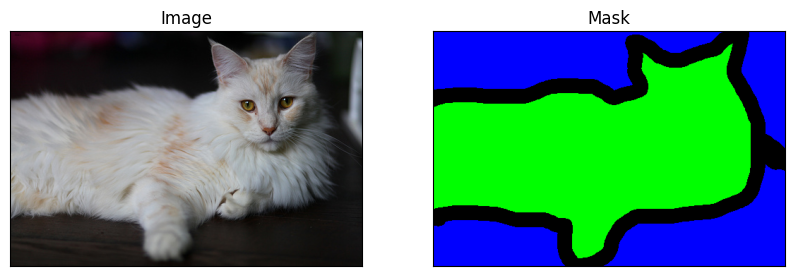

In [326]:
imgage, mask = dataset[600]
image_utils.visualiseData(image = imgage, mask = mask)